In [4]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pystan
import pickle
%matplotlib inline
import vincent
from IPython.display import display

In [6]:
pd.set_option('display.max_columns', 50)

In [4]:
import us
state_map = us.states.mapping('abbr', 'name')

In [8]:
names = ('Tornado Number','Year','Month','Day','Date','Time','Time Zone','State','State ID','State Number',\
         'Scale','Injuries','Fatalities','Property Loss','Crop Loss','Starting Lat','Starting Lon',\
         'Ending Lat','Ending Lon','Length','Width','Number of States','State Flag','Segment Number',\
         '1st County','2nd County','3rd County','4th County','Wind')

In [317]:
data = pd.read_csv('1950-2014_torn.csv',names=names)
data = data.query('Year >= 1985')

In [318]:
states = data['State'].unique()
years = data['Year'].unique()
state_IDs = data['State ID'].unique()
state_dict = {}
for i,state in enumerate(states):
    state_dict[states[i]]=i
state_ID_dict = {}
for i,ID in enumerate(state_IDs):
    state_ID_dict[ID]=i
year_dict = {}
j=0
for i,year in enumerate(years):
    year_dict[year]=j
    if i%3==2:
        j+=1
    
counties = np.array(list(set([str(x).zfill(2)+str(y).zfill(3) for x,y in zip(data['State ID'].values,data['1st County'].values) if y!=0]+\
    [str(x).zfill(2)+str(y).zfill(3) for x,y in zip(data['State ID'].values,data['2nd County'].values) if y!=0]+\
    [str(x).zfill(2)+str(y).zfill(3) for x,y in zip(data['State ID'].values,data['3rd County'].values) if y!=0]+\
    [str(x).zfill(2)+str(y).zfill(3) for x,y in zip(data['State ID'].values,data['4th County'].values) if y!=0])))

county_dict = {}
for i,k in enumerate(counties):
    county_dict[k]=i

t_data_full = np.zeros((len(counties),len(years)),dtype=int)

In [60]:
# t_data_full = np.zeros((len(counties),len(years),6),dtype=int)
# for i in data.index:
#     row = data.ix[i]
#     scale = row['Scale']
#     if row['State Flag'] ==1 and scale>=0:
#         if row['1st County']!=0:
#             t_data_full[county_dict[str(row['State ID']).zfill(2)+str(row['1st County']).zfill(3)]][year_dict[row['Year']]][scale]+=1
#         if row['2nd County']!=0:
#             t_data_full[county_dict[str(row['State ID']).zfill(2)+str(row['2nd County']).zfill(3)]][year_dict[row['Year']]][scale]+=1
#         if row['3rd County']!=0:
#             t_data_full[county_dict[str(row['State ID']).zfill(2)+str(row['3rd County']).zfill(3)]][year_dict[row['Year']]][scale]+=1  
#         if row['4th County']!=0:
#             t_data_full[county_dict[str(row['State ID']).zfill(2)+str(row['4th County']).zfill(3)]][year_dict[row['Year']]][scale]+=1

In [319]:
t_data_full = np.zeros((len(counties),len(np.unique(year_dict.values())),3),dtype=int)
for i in data.index:
    row = data.ix[i]
    scale = row['Scale']
    if row['State Flag'] ==1 and scale>=0:
        if row['1st County']!=0:
            if scale ==0 or scale==1:
                t_data_full[county_dict[str(row['State ID']).zfill(2)+str(row['1st County']).zfill(3)]][year_dict[row['Year']]][0]+=1
            if scale ==2 or scale==3:
                t_data_full[county_dict[str(row['State ID']).zfill(2)+str(row['1st County']).zfill(3)]][year_dict[row['Year']]][1]+=1
            if scale ==4 or scale==5 or scale >5:
                t_data_full[county_dict[str(row['State ID']).zfill(2)+str(row['1st County']).zfill(3)]][year_dict[row['Year']]][2]+=1
#         if row['2nd County']!=0:
#             t_data_full[county_dict[str(row['State ID']).zfill(2)+str(row['2nd County']).zfill(3)]][year_dict[row['Year']]][scale]+=1
#         if row['3rd County']!=0:
#             t_data_full[county_dict[str(row['State ID']).zfill(2)+str(row['3rd County']).zfill(3)]][year_dict[row['Year']]][scale]+=1  
#         if row['4th County']!=0:
#             t_data_full[county_dict[str(row['State ID']).zfill(2)+str(row['4th County']).zfill(3)]][year_dict[row['Year']]][scale]+=1

In [320]:
county_land_mass_df = pd.read_csv('County_land_mass.csv')
states_used = ['MT','WY','CO','ND','SD','NE','KS','OK','MN','IA','MO','AR']
#states_used=[st for st in states if st not in ['DC']]

county_state_list = []
used_inds = []
for i in range(len(counties)):
    if states[state_ID_dict[int(counties[i][0:2])]] in states_used and int(counties[i]) in county_land_mass_df['STCOU'].values\
        and (int(counties[i])<51500 or int(counties[i])>=52000):
        used_inds.append(i)
        county_state_list.append(state_ID_dict[int(counties[i][0:2])])
t_data = t_data_full[used_inds]
county_state_list = np.array(county_state_list)

county_state_map = np.zeros_like(county_state_list)
for i,st in enumerate(county_state_list):
    county_state_map[i] = np.where(st==np.unique(county_state_list))[0]
    
county_land_mass = np.zeros(len(used_inds))
for i,ct in enumerate(counties[used_inds]):
    county_land_mass[i] = county_land_mass_df[county_land_mass_df['STCOU'] == int(ct)]['Land_mass'].values[0]

In [321]:
tornado_code = """
data {
    int<lower=0> N_obs; // Number of observations
    int<lower=0> N_yr; // Number of years
    int<lower=0> N_st; // Number of states
    int<lower=0> N_ct; // Number of counties
    int<lower=0> N_sc; // Number of f-scales
    real land_mass[N_ct]; // Land mass of counties
    int<lower=0> y[N_obs]; // Tornado number
    int<lower=0> county_state[N_ct]; // State in which county is in
}
parameters {
  //  real land_mass_factor;
  
    vector[N_sc*N_ct] county_factor;
    vector[N_sc*N_st] county_mu;
    vector<lower=0>[N_sc*N_st] county_sig;
    
    vector[N_sc*N_yr] year_factor;
    vector<lower=0>[N_sc] year_sig;

    vector[N_obs] noise_factor;
    vector<lower=0>[N_sc] noise_sig;
 
}
transformed parameters {
    //vector[N_obs] lambda;
    vector[N_obs] lambda;
    for (i in 1:N_ct) {
        for (j in 1:N_yr) {
            for (f in 1:N_sc) {
                lambda[(i-1)*N_yr*N_sc + (j-1)*N_sc + f] <- exp(
                year_factor[(j-1)*N_sc + f] + county_factor[(i-1)*N_sc + f] + log(land_mass[i]/100.0)
                + noise_factor[(i-1)*N_yr*N_sc + (j-1)*N_sc + f]) ;
            }
        }
    }
}
model  {
 //   county_mu ~ normal(0,5);
    county_sig ~ cauchy(0,0.05);
    for (i in 1:N_ct) {
        for (f in 1:N_sc) {
            county_factor[(i-1)*N_sc + f] ~ 
            normal(county_mu[(county_state[i]-1)*N_sc + f],county_sig[(county_state[i]-1)*N_sc + f]);
        }
    }
    year_sig ~ cauchy(0,0.1);
    for (j in 1:N_yr) {
        for (f in 1:N_sc) {
            year_factor[(j-1)*N_sc + f] ~ normal(0,year_sig[f]);
        }
    }
    noise_sig ~ cauchy(0,0.1);
    for (i in 1:N_ct) {
        for (j in 1:N_yr) {
            for (f in 1:N_sc) {
                noise_factor[(i-1)*N_yr*N_sc + (j-1)*N_sc + f] ~ normal(0,noise_sig[f]);
            }
        }
    }
    y ~ poisson(lambda);

}
"""

In [322]:
tornado_dat = {'N_obs':t_data.shape[0]*t_data.shape[1]*t_data.shape[2],
                'N_yr':t_data.shape[1],
               'N_st':len(states_used),
               'N_ct':t_data.shape[0],
               'N_sc':t_data.shape[2],
               'land_mass':county_land_mass,
               'y':t_data.flatten(),
              'county_state':np.array(county_state_map+1,dtype=int)}

In [164]:
fit = pystan.stan(model_code=tornado_code, data=tornado_dat,iter=1000,chains=1)

In [165]:
post_means = fit.get_posterior_mean()

In [166]:
pickle.dump(post_means, open( "post_means.pickle", "wb" ) )

In [69]:
la = fit.extract(permuted=True)

//anaconda/lib/python2.7/pickle.py:306: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  rv = reduce(self.proto)


In [88]:
pickle.dump(la, open( "la.pickle", "wb" ) )

[u'county_factor',
 u'county_mu',
 u'county_sig',
 u'year_factor',
 u'year_sig',
 u'noise_factor',
 u'noise_sig',
 u'lambda']

In [ ]:
c_mu = post_means[[i for i,f in enumerate(fit.flatnames) if str(f)[0:8] == 'county_m']].reshape(t['N_st'],t['N_sc'])
c_sig = post_means[[i for i,f in enumerate(fit.flatnames) if str(f)[0:8] == 'county_s']].reshape(t['N_st'],t['N_sc'])
c_fac = post_means[[i for i,f in enumerate(fit.flatnames) if str(f)[0:8] == 'county_f']].reshape(t['N_ct'],t['N_sc'])

In [193]:
bla = []
state_ind_map = {}
for i,st in enumerate(states[county_state_list]):
    if st not in bla:
        state_ind_map[county_state_map[i]]=st
    bla.append(st)

In [197]:
for i in range(len(state_ind_map)):
    if state_ind_map[i] in ['MA','OK','AL','CO']:
        print state_ind_map[i]
        for j in [0,1,2]:
            print c_mu[i][j],c_sig[i][j]

OK
0.689256991094 0.248593924404
0.9832512982 0.339980877739
1.84095086307 0.895325213746
AL
0.485126043031 0.320789377485
1.00554254747 0.450557837928
2.1543194541 0.354313114176
CO
-0.607544037438 1.66817351782
-1.4947202908 1.45048783981
-2.75471032896 0.121786192771
MA
-0.961554420716 0.106449012326
-0.855357330434 0.122681417851
0.556329370565 0.781123136805


In [20]:
county_topo = r'us_counties.topo.json'
#state_topo = r'http://github.com/wrobstory/vincent_map_data/blob/f9300df977b32bd897da08126f7324552054ec88/us_states.topo.json'
geo_data = [{'name': 'counties',
             'url': county_topo,
             'feature': 'us_counties.geo'}]

In [176]:
post_means = fit.get_posterior_mean()
t = tornado_dat
county_means = np.exp(post_means[0:t['N_sc']*t['N_ct']].reshape((t['N_ct'],t['N_sc'])))
post_year_inds = [i for i,f in enumerate(fit.flatnames) if str(f)[0:6] == 'year_f']
yrs = post_means[post_year_inds].reshape(t['N_yr'],t['N_sc'])
county_df_dict = {}
county_df_dict['NAME'] = []
county_df_dict['tornado0'] = []
county_df_dict['tornado1'] = []
county_df_dict['tornado2'] = []
for i,ct in enumerate(counties[used_inds]):
    state = county_state_map[i]
    county_df_dict['NAME'].append(ct)
    county_df_dict['tornado0'].append(county_means[i,0])
    county_df_dict['tornado1'].append(county_means[i,1])
    county_df_dict['tornado2'].append(county_means[i,2])
    #     county_df_dict['tornado'].append(np.exp(county_means[i][0]+state_factor[0]-np.mean(sorted_county_means[int(state)])))
    #county_df_dict['tornado'].append(t_data.mean(axis=1)[county_dict[ct]])
county_df = pd.DataFrame(county_df_dict)
vis0 = vincent.Map(data=county_df, geo_data=geo_data, scale=1000,
                  projection='albersUsa', data_bind='tornado0', data_key='NAME',
                  map_key={'counties': 'properties.FIPS'}, brew='YlGnBu')
vis1 = vincent.Map(data=county_df, geo_data=geo_data, scale=1000,
                  projection='albersUsa', data_bind='tornado1', data_key='NAME',
                  map_key={'counties': 'properties.FIPS'}, brew='YlGnBu')
vis2 = vincent.Map(data=county_df, geo_data=geo_data, scale=1000,
                  projection='albersUsa', data_bind='tornado2', data_key='NAME',
                  map_key={'counties': 'properties.FIPS'}, brew='YlGnBu')

In [ ]:
vis0.display()

In [186]:
vis1.display()

In [183]:
dvis2.display()

In [714]:
get_params2('OK',1980,499)

state factor= 26.2653250695
state noise= -22.0682729164
year factor= -90.4775133363
year noise= 89.4574606701
noise factor= -0.395536476775
sum= -64.6077247437
-------------
lambda= 16.1426204959


In [729]:
def get_params(state,year,it):
    print 'state factor=',la['state_factor'][it][state_dict[state]]
    print 'year factor=',la['year_factor'][it][year_dict[year]]
    print 'noise factor=',la['noise_factor'][it][state_dict[state]*len(years)+year_dict[year]]
    print 'sum=',la['state_factor'][it][state_dict[state]]+la['year_factor'][it][year_dict[year]]+\
    la['noise_factor'][it][state_dict[state]*len(years)+year_dict[year]]
    print '-------------'
    print 'lambda=',la['lambda'][it][state_dict[state]*len(years)+year_dict[year]]

In [713]:
def get_params2(state,year,it):
    print 'state factor=',la['state_factor'][it][state_dict[state]]
    print 'state noise=',la['state_error'][it][state_dict[state]]
    print 'year factor=',la['year_factor'][it][year_dict[year]]
    print 'year noise=',la['year_error'][it][year_dict[year]]
    print 'noise factor=',la['noise_factor'][it][state_dict[state]*len(years)+year_dict[year]]
    print 'sum=',la['state_factor'][it][state_dict[state]]+la['year_factor'][it][year_dict[year]]+\
    la['noise_factor'][it][state_dict[state]*len(years)+year_dict[year]]
    print '-------------'
    print 'lambda=',la['lambda'][it][state_dict[state]*len(years)+year_dict[year]]

In [ ]:
la['year_factor'][-120]

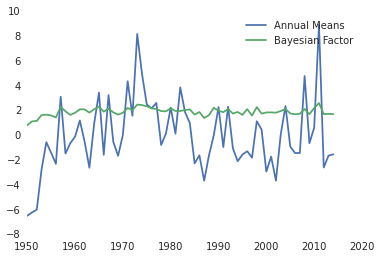

In [738]:
t_mean = np.mean(t_data)
N_yr = len(years)
yearly_means = np.zeros(N_yr)
for yr in range(N_yr):
    yearly_means[yr] = np.mean(t_data[:,yr])
plt.plot(years,yearly_means-t_mean,label='Annual Means')
plt.plot(years,np.exp(la['year_factor'][-120],label='Bayesian Factor')
plt.legend()

(0, 125)

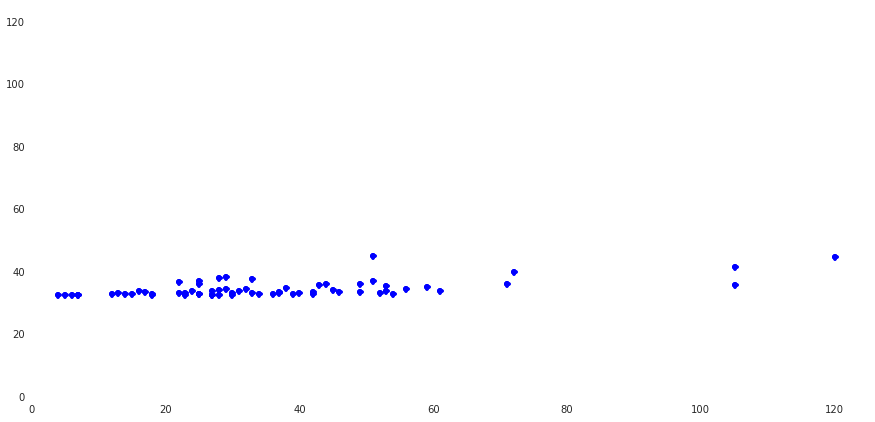

In [67]:
plt.figure(figsize=(15,7))
IA_arr = la['lambda'][-1][state_dict['IA']*N_yr:state_dict['IA']*N_yr+N_yr]
plt.plot(t_data[state_dict['IA']],IA_arr,'bo')
plt.xlim(0,125)
plt.ylim(0,125)

In [16]:
state_topo = r'us_states.topo.json'
#state_topo = r'http://github.com/wrobstory/vincent_map_data/blob/f9300df977b32bd897da08126f7324552054ec88/us_states.topo.json'
geo_data2 = [{'name': 'states',
             'url': state_topo,
             'feature': 'us_states.geo'}]

In [120]:
import vincent
from IPython.display import display
county_topo = r'us_counties.topo.json'
#state_topo = r'http://github.com/wrobstory/vincent_map_data/blob/f9300df977b32bd897da08126f7324552054ec88/us_states.topo.json'
geo_data = [{'name': 'counties',
             'url': county_topo,
             'feature': 'us_counties.geo'}]

In [245]:
fit.model_pars

[u'county_factor',
 u'county_mu',
 u'county_sig',
 u'year_factor',
 u'year_sig',
 u'noise_factor',
 u'noise_mu',
 u'noise_sig',
 u'lambda']

In [556]:
post_means = fit.get_posterior_mean()

In [557]:
t = tornado_dat

In [558]:
county_means = np.exp(post_means[0:t['N_sc']*t['N_ct']].reshape((t['N_sc'],t['N_ct']))).sum(axis=0)

In [559]:
year_means = np.exp(post_means[t['N_sc']*t['N_ct'] + 2*t['N_sc']*t['N_st']:t['N_sc']*t['N_ct'] + 2*t['N_sc']*t['N_st'] + t['N_sc']*t['N_yr']]\
    .reshape((t['N_sc'],t['N_yr'])))

In [560]:
t_data[:,5][5]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [561]:
foo = la['county_factor'].reshape((25,t['N_sc'],t['N_ct']))

ValueError: total size of new array must be unchanged

In [579]:
post_lam_inds = [i for i,f in enumerate(fit.flatnames) if str(f)[0:6] == 'lambda']

In [580]:
post_noise_inds = [i for i,f in enumerate(fit.flatnames) if str(f)[0:7] == 'noise_f']

In [581]:
post_year_inds = [i for i,f in enumerate(fit.flatnames) if str(f)[0:6] == 'year_f']

In [582]:
post_syear_inds = [i for i,f in enumerate(fit.flatnames) if str(f)[0:6] == 'year_s']

In [583]:
post_county_inds = [i for i,f in enumerate(fit.flatnames) if str(f)[0:8] == 'county_f']

In [43]:
post_cm_inds = [i for i,f in enumerate(fit.flatnames) if str(f)[0:8] == 'county_m']

In [44]:
post_cs_inds = [i for i,f in enumerate(fit.flatnames) if str(f)[0:8] == 'county_s']

In [45]:
post_f_inds = [i for i,f in enumerate(fit.flatnames) if str(f)[0:8] == 'f_factor']

In [48]:
stm = post_means[post_cm_inds]
sts = post_means[post_cs_inds]
fs =  post_means[post_f_inds].reshape(6,5)

In [47]:
fs.shape

(30, 1)

In [35]:
fs

array([[-3.72677124],
       [-4.24811681],
       [-5.21269891],
       [-6.06828124],
       [-6.85147223],
       [-7.21045866]])

In [31]:
states_used

['OK', 'KS', 'NE', 'MO', 'CO', 'NM', 'MA', 'OR', 'NH', 'AL']

In [50]:
for i,s in enumerate(states_used):
    print s,stm[i],sts[i],fs[4][i]

OK [-0.2357069] [ 0.41979977] -4.3072949128
NE [ 0.14698599] [ 1.72374938] -5.69208290768
CO [-0.16397231] [ 0.58819584] -4.9611602256
MA [ 0.28135971] [ 2.8993147] -3.21395536207
OR [-0.28841192] [ 0.92906883] -6.52191066497


In [585]:
bla = post_means[post_lam_inds].reshape(t_data.shape[0],t_data.shape[1],t_data.shape[2])

In [586]:
ys = post_means[post_syear_inds].reshape(6)

In [587]:
ys

array([  0.73782312,   0.45028125,   5.80660247,   9.18365528,
        19.68552382,  21.19342825])

In [588]:
post_year_inds = [i for i,f in enumerate(fit.flatnames) if str(f)[0:6] == 'year_f']
y = post_means[post_year_inds].reshape(6,35)

In [589]:
n = post_means[post_noise_inds].reshape(6,153,35)
y = post_means[post_year_inds].reshape(6,35)
c = post_means[post_county_inds].reshape(6,153)

In [603]:
np.log(county_land_mass/100.0).mean()

2.4389839951664665

In [601]:
c[5][7]

0.46979959583914105

In [596]:
print np.log(county_land_mass[1]/100.)
print y[5][-2]
print n[5][1][-2]
print c[5][1]

1.71988745699
-7.00895686303
0.323696247826
1.76982552053


In [600]:
county_df

,NAME,tornado0,tornado2,tornado5
0,08115,0.060234,0.069352,0.228100
1,40027,0.048369,1.188825,5.869829
2,53025,0.003446,0.018028,0.145813
3,53021,0.003423,0.020835,0.092530
4,08059,0.008761,0.134915,0.216173
5,08055,0.002641,0.062350,0.210880
6,53035,0.003595,0.021758,0.178536
7,40081,0.051190,1.270373,1.599674
8,40083,0.060794,0.958215,4.335527
9,40085,0.041522,0.878535,1.315621


In [599]:
c[5][1]

1.7698255205320466

In [594]:
np.exp(np.log(county_land_mass[2]/100.)+y[5][-2]+n[5][2][-2]+c[5][2])

0.0018866941266139994

In [595]:
bla[5][2][-2]

0.0051673110113058451

In [396]:
bla[1][500]

array([ 0.01666989,  0.52083316,  0.0452525 ,  0.10652973,  0.0537307 ,
        0.07537061,  0.16825491,  0.03016391,  0.13906724,  0.0856805 ,
        0.58289176,  0.02118884,  0.62230209,  0.05499352,  0.03678919,
        0.07458012,  0.59878971,  0.45610898,  0.05296296,  0.07329915,
        0.03822587,  0.05611126,  0.10903388,  0.2461199 ,  0.52644917,
        0.67641997,  0.02272711,  0.05078703,  0.46592197,  0.72266446,
        0.34177946,  0.71576227,  0.04473933,  0.1108418 ,  0.02755007])

In [382]:
bla.shape

(1473,)

In [411]:
cs = post_means[post_cs_inds].reshape(6,t['N_st'])

In [400]:
states_used

['OK',
 'KS',
 'NE',
 'IA',
 'MO',
 'CO',
 'IL',
 'AR',
 'SD',
 'WY',
 'MN',
 'TX',
 'LA',
 'NM',
 'MA',
 'OR',
 'WA',
 'NH',
 'AL',
 'NC',
 'MN']

In [ ]:
t_data[:,

In [429]:
county_land_mass_df = pd.read_csv('County_land_mass.csv')
#states_used=['CO','NE']   
# states_used=['OK','KS','NE','IA','MO']   
states_used=['OK']   

county_state_list = []
used_inds = []
for i in range(len(counties)):
    if states[state_ID_dict[int(counties[i][0:2])]] in states_used and int(counties[i]) in county_land_mass_df['STCOU'].values:
        used_inds.append(i)
        county_state_list.append(state_ID_dict[int(counties[i][0:2])])
t_data2 = t_data_full[:,used_inds]

In [430]:
county_land_mass_df = pd.read_csv('County_land_mass.csv')
#states_used=['CO','NE']   
# states_used=['OK','KS','NE','IA','MO']   
states_used=['WA']   

county_state_list = []
used_inds = []
for i in range(len(counties)):
    if states[state_ID_dict[int(counties[i][0:2])]] in states_used and int(counties[i]) in county_land_mass_df['STCOU'].values:
        used_inds.append(i)
        county_state_list.append(state_ID_dict[int(counties[i][0:2])])
t_data3 = t_data_full[:,used_inds]

In [441]:
f=4
print t_data2[f].mean()
print t_data3[f].mean()

0.0163265306122
0.0


In [428]:
print t_data[0].mean()

0.0605714285714


In [412]:
cs[:][0].mean()

-0.026252677202123858

In [418]:
cs[:][-5].mean()

0.22064081075213679

In [303]:
n = post_means[post_noise_inds].reshape(6,489,35)

In [ ]:
y = post_means[post_year_inds].reshape(6,35)

In [309]:
n = post_means[post_noise_inds].reshape(6,489,35)
y = post_means[post_year_inds].reshape(6,35)
c = post_means[post_county_inds].reshape(6,489)

In [311]:
c[5]

array([-1.93378338, -2.30875144, -4.64389691, -4.10022116, -5.07652173,
        4.20018407, -2.63233206, -1.31735638, -5.06713288, -1.91956767,
       -4.60854208, -4.99596594, -3.16313343, -4.34693147, -3.59142752,
       -2.70834971, -2.2743764 , -4.09887662, -2.71426654, -2.13299054,
       -4.65505067, -4.30757311, -4.54053675, -1.32839919, -3.75392338,
       -2.20742354, -1.99593835, -2.94167948, -3.53117749, -3.75908161,
       -3.44059152, -2.70201807, -1.27547357, -4.55515361, -0.71579543,
        2.24545634, -1.26330425,  4.61339215, -7.47475196, -3.83957913,
       -4.69626802, -9.64140096, -3.68977921, -3.97642893, -3.50064011,
       -4.21915736, -3.23149217, -2.55446813, -3.78249721, -4.22593984,
       -1.03488919, -3.5403596 , -3.00880306, -2.75060406, -1.49177318,
       -3.60148187, -3.82507956, -2.93505134, -3.65088345, -4.5679528 ,
       -4.54722465, -2.15298083,  2.33183595, -6.01876733, -1.19481867,
       -3.69804055, -2.21650412, -4.71083491, -3.09454699, -3.25

In [307]:
y[5]

array([-41.66184993, -57.05339117,  -9.46549828, -73.52783767,
       -58.0814366 , -50.33569431, -74.34687345, -28.96380114,
       -60.97997385, -44.52493722,  -7.95808775,  -9.10634843,
       -26.5617912 , -46.58333857, -36.3708194 , -47.59042805,
       -43.04466354, -47.75418117, -54.20156372,  -8.47034523,
       -70.36280356, -61.84971249, -45.85791714, -26.06596557,
       -49.4826333 , -56.37092663, -66.06675614,  -9.25992586,
        -8.59922559, -67.57379287, -38.20474807,  -8.05669731,
       -60.82290869,  -9.53727779, -65.05313158])

In [304]:
n[5][5]

array([ 0.26551791,  0.03484376,  0.0618499 , -0.00515412, -0.07277138,
       -0.05563477,  0.32499587,  0.14740903,  0.08250262, -0.03175219,
       -0.16515874, -0.42529099, -0.081238  , -0.23934666,  0.01093372,
        0.31575475,  0.42461168,  0.14796811, -0.17797113,  0.83662238,
        0.12360584,  0.07317805,  0.08850743,  0.42191939,  0.14056578,
        0.21764796,  0.27315235, -0.07708065,  0.26156627,  0.0837147 ,
       -0.02338642, -0.29902593,  0.05032701,  1.0879659 ,  0.01919246])

In [295]:
bla[5][5]

array([  6.93951995e-14,   7.87403151e-21,   1.21254493e-01,
         8.00750998e-29,   4.02296477e-22,   6.25344647e-16,
         8.53552994e-29,   2.59481920e-09,   9.33294622e-22,
         2.41541806e-12,   1.62531386e-01,   6.55840754e-02,
         1.18290324e-07,   8.29199335e-17,   6.76269718e-13,
         5.68766562e-16,   2.08342995e-14,   7.26136206e-17,
         1.34722224e-18,   2.37455990e-01,   2.17054257e-27,
         2.59685946e-23,   2.10054315e-17,   3.88099542e-04,
         1.59253011e-18,   1.74341112e-20,   1.21336270e-25,
         7.21416666e-02,   1.70092264e-01,   1.57094835e-25,
         7.20246935e-12,   2.26146176e-01,   8.39990377e-23,
         1.49891539e-01,   2.92276577e-22])

In [288]:
'lambda[102689]'[0:6]

'lambda'

In [331]:
county_means[:,80]

array([ 1.11192187,  0.39911482,  1.86888632,  0.27693644,  0.53011856,
        0.84543067])

In [375]:
sorted_county_means = [[] for i in range(len(states_used))]
for i,ct in enumerate(counties[used_inds]):
    sorted_county_means[int(county_state_map[i])].append(county_means[i])

In [209]:
state_df_dict = {}
state_df_dict['NAME'] = []
state_df_dict['tornado'] = []
for i,st in enumerate(states_used):
    state_df_dict['NAME'].append(state_map[st])
    state_df_dict['tornado'].append(np.exp(state_means[i][0] + np.mean(sorted_county_means[i])))
state_df = pd.DataFrame(state_df_dict)

In [448]:
county_df_dict = {}
county_df_dict['NAME'] = []
county_df_dict['tornado'] = []
for i,ct in enumerate(counties[used_inds]):
    state = county_state_map[i]
    county_df_dict['NAME'].append(ct)
#     county_df_dict['tornado'].append(np.exp(county_means[i]-np.mean(sorted_county_means[int(state)])))
    county_df_dict['tornado'].append(county_means[i])
#     county_df_dict['tornado'].append(np.exp(county_means[i][0]+state_factor[0]-np.mean(sorted_county_means[int(state)])))
    #county_df_dict['tornado'].append(t_data.mean(axis=1)[county_dict[ct]])
county_df = pd.DataFrame(county_df_dict)

In [383]:
county_df_dict = {}
county_df_dict['NAME'] = []
county_df_dict['tornado'] = []
for i,ct in enumerate(counties[used_inds]):
    state = county_state_map[i]
    county_df_dict['NAME'].append(ct)
#     county_df_dict['tornado'].append(np.exp(county_means[i]-np.mean(sorted_county_means[int(state)])))
    county_df_dict['tornado'].append(bla[i])
#     county_df_dict['tornado'].append(np.exp(county_means[i][0]+state_factor[0]-np.mean(sorted_county_means[int(state)])))
    #county_df_dict['tornado'].append(t_data.mean(axis=1)[county_dict[ct]])
county_df = pd.DataFrame(county_df_dict)

In [211]:
mean_county_factor = np.mean(np.exp(county_means))
full_df_dict = {}
full_df_dict['NAME'] = []
full_df_dict['tornado'] = []
for i,ct in enumerate(counties[used_inds]):
    full_df_dict['NAME'].append(ct)
    full_df_dict['tornado'].append(np.exp(county_means[i][0]+state_means[county_state_map[i]][0]))
    #county_df_dict['tornado'].append(t_data.mean(axis=1)[county_dict[ct]])
full_df = pd.DataFrame(full_df_dict)

In [449]:
vis = vincent.Map(data=county_df, geo_data=geo_data, scale=1000,
                  projection='albersUsa', data_bind='tornado', data_key='NAME',
                  map_key={'counties': 'properties.FIPS'}, brew='YlGnBu')

In [213]:
vis2 = vincent.Map(data=state_df, geo_data=geo_data2, scale=1000,
                  projection='albersUsa', data_bind='tornado', data_key='NAME',
                  map_key={'states': 'properties.NAME'}, brew='YlGnBu')

In [214]:
vis3 = vincent.Map(data=full_df, geo_data=geo_data, scale=1000,
                  projection='albersUsa', data_bind='tornado', data_key='NAME',
                  map_key={'counties': 'properties.FIPS'}, brew='YlGnBu')

In [279]:
us.states.lookup('08001')

In [273]:
full_df.sort('tornado',ascending=False)

,NAME,tornado
844,08001,0.362064
670,20009,0.308790
1119,20181,0.268050
928,05085,0.264127
994,22055,0.263591
194,05119,0.259192
7,22001,0.258291
842,08005,0.248063
818,20151,0.219777
1023,29201,0.218056


In [238]:
county_land_mass.shape

(1232,)

In [247]:
np.where(counties=='42159')

(array([292]),)

In [245]:
ct

'42159'

In [252]:
data[np.logical_and(data['1st County']==159,data['State ID']==42)]

,Tornado Number,Year,Month,Day,Date,Time,Time Zone,State,State ID,State Number,Scale,Injuries,Fatalities,Property Loss,Crop Loss,Starting Lat,Starting Lon,Ending Lat,Ending Lon,Length,Width,Number of States,State Flag,Segment Number,1st County,2nd County,3rd County,4th County,Wind
36601,1152,1996,6,22,1996-06-22,13:00:00,3,PA,42,3,1,0,0,1.4,0,41.63,-76.23,41.33,-75.73,13.5,100,1,1,1,159,131,79,0,NaN


In [244]:
county_land_mass_df[county_land_mass_df['STCOU'] == int(ct)]

,STCOU,Land_mass


In [255]:
county_land_mass = np.zeros(len(counties))+100000.0
for i,ct in enumerate(counties):
    if len(county_land_mass_df[county_land_mass_df['STCOU'] == int(ct)]>0):
        county_land_mass[i] = county_land_mass_df[county_land_mass_df['STCOU'] == int(ct)]['Land_mass'].values[0]

In [256]:
toverl = np.zeros_like(t_data_full.mean(axis=1))
for i,n in enumerate(t_data_full.mean(axis=1)):
    county = counties[i]
    lm = county_land_mass[i]
    toverl[i] = n/lm

In [258]:
np.argsort(toverl)[::-1]

array([ 401,  620, 2580, ...,   34, 2308,  292])

In [268]:
counties[np.argsort(toverl)[::-1][9]]

'51540'

In [226]:
np.argmax(t_data_full.mean(axis=1))

1302

In [227]:
counties[1302]

'08123'

In [237]:
states[state_ID_dict[8]]

'CO'

In [242]:
np.argsort(t_data.mean(axis=1))[::-1]

array([2477,  720, 2040, ..., 2029,    0, 1967])

In [744]:
get_params('OK',1980,499)

state factor= 5.33384253857
year factor= -1.75115982774
noise factor= -0.447086677896
sum= 3.13559603293
-------------
lambda= 23.0023419104


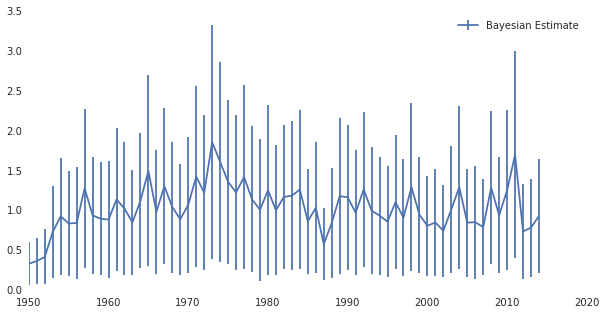

In [769]:
fig = plt.figure(figsize=(10,5))
#plt.errorbar(years,np.mean(np.exp(la['year_factor']-la['year_factor'].mean()),axis=0),yerr=np.std(np.exp(la['year_factor']),axis=0),label='Bayesian Estimate')
plt.errorbar(years,np.exp(np.mean(la['year_factor']-la['year_factor'].mean(),axis=0)),yerr=np.std(np.exp(la['year_factor']),axis=0),label='Bayesian Estimate')
#plt.plot(years,np.exp(np.mean(la['year_factor']-la['year_factor'].mean(),axis=0)))
#plt.errorbar(years,yearly_means-t_mean,np.std(yearly_means),label='Annual Means')
plt.legend()

In [775]:
np.exp(la['year_factor']).shape

(1000, 65)

<Container object of 3 artists>

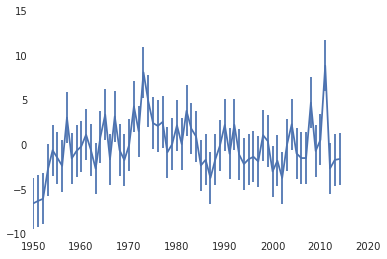

In [782]:
plt.errorbar(years,yearly_means-t_mean,np.std(yearly_means),label='Annual Means')

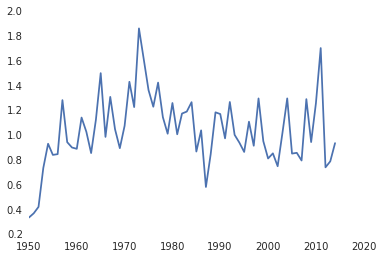

In [784]:
plt.plot(years,np.exp(np.mean(la['year_factor']-la['year_factor'].mean(),axis=0)))
#plt.errorbar(years,yearly_means-t_mean,np.std(yearly_means),label='Annual Means')

In [734]:
tornado_arr = []
lambda_arr = []
for i in range(1000):
    noise_sig = np.random.choice(la2['noise_hp_sig'])
    noise = np.random.normal(0,noise_sig)
    state_factor = np.random.choice(la2['state_factor'][:,state_dict['MA']])
    year_factor = np.random.choice(la2['year_factor'][:,60:65].flatten())
    tornado_number = np.random.poisson(np.exp(noise+state_factor+year_factor))
    lambda_arr.append(np.exp(noise+state_factor+year_factor))
    tornado_arr.append(tornado_number)

(array([ 0.30111111,  0.15777778,  0.06055556,  0.02222222,  0.005     ,
         0.00111111,  0.00388889,  0.00055556,  0.00166667,  0.00166667]),
 array([  0. ,   1.8,   3.6,   5.4,   7.2,   9. ,  10.8,  12.6,  14.4,
         16.2,  18. ]),
 <a list of 10 Patch objects>)

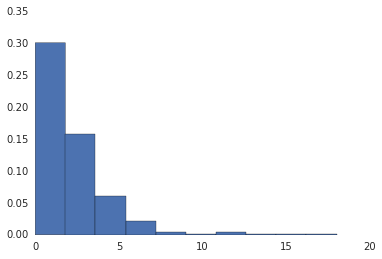

In [735]:
plt.hist(tornado_arr,normed=True)

In [442]:
print np.mean(la['state_factor'][:,state_dict['NE']])
print np.mean(la['year_factor'][:,64])
print np.mean(la['noise_hp_sig'])

2.39319603882
1.45462028645
0.573835633708


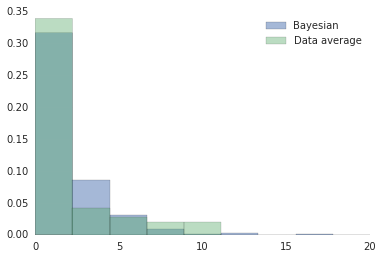

In [791]:
plt.hist(tornado_arr,normed=True,alpha=0.5,bins=np.linspace(0,20,10),label='Bayesian')
plt.hist(t_data[state_dict['MA']],normed=True,alpha=0.4,bins=np.linspace(0,20,10),label='Data average')
plt.legend()
plt.show()